# Deep Learning Project - Group 6
Bruna Faria | 20211529; 
Catarina Oliveira | 20211616;
Inês Vieira | 20211589;
Joana Rosa | 20211516;
Rita Centeno | 20211579


## **Building the Model**

#### Table of Contents:
1. [Library Imports](#import-libraries)
2. [Open Data](#opening-data)
3. [EDA](#eda)
4. [Preprocessing](#initial-preprocessing)
5. [Train Test Split](#train-test-split)
6. [Oversampling](#oversampling)
7. [Modeling](#modeling)
8. [Model Evaluation](#model-evaluation)
9. [Exports](#exports)

### Importing Necessary Libraries
<a id='import-libraries'></a>

In [2]:
# Imports

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow
# !pip install pillow
# !pip install opencv-python
# !pip install scikit-learn
# !pip install keras
# !pip install imbalanced-learn


# Importing standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Importing image libraries
from PIL import Image, ImageEnhance
import cv2

# Importing scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers

# Importing imblearn libraries
from imblearn.over_sampling import RandomOverSampler

# Import pretrained models
from tensorflow.keras.applications import (ResNet50, InceptionV3, DenseNet121, VGG16, Xception)

# Importing model evaluation libraries
from tensorflow.keras.models import load_model

# Import garbage collector to free up memory
import gc

# Import warnings to silence warnings
import warnings
warnings.filterwarnings('ignore')

# Importing custom functions
from path import path
from utils import *

%load_ext autoreload
%autoreload 2

### Opening Data
<a id='opening-data'></a>

In [2]:
metadata = pd.read_csv(path + "data//HAM10000_metadata.csv")

In [3]:
# Paths
train_dir = path + "data//train"
test_dir = path + "data//test"

In [4]:
# Create empty lists to store labels and the arrays of images
labels_train = []
images_data_train = []
labels_test = []
images_data_test = []

# Load images and labels
for index, row in metadata.iterrows():
    image_name = row['image_id'] + ".jpg"
    label = row['dx']

    # Check if the image belongs to the training set
    if os.path.exists(os.path.join(train_dir, image_name)):

        # Load image
        image_path = os.path.join(train_dir, image_name) 
        img = Image.open(image_path)
        img = np.array(img)

        # Assign image to train set
        metadata.at[index, 'train'] = 1 
           
        # Append image and respective label to list
        labels_train.append(label) 
        images_data_train.append(img)

    elif os.path.exists(os.path.join(test_dir, image_name)):

        # Load image
        image_path = os.path.join(test_dir, image_name)
        img = Image.open(image_path)
        img = np.array(img)

        # Assign image to test set
        metadata.at[index, 'train'] = 0

        # Append image and respective label to list
        labels_test.append(label)
        images_data_test.append(img)

    # Error message if image is not found
    else:
        print(f"Image not found: {image_name}")

In [5]:
# Throughout this notebook there will be several deletions of no longer needed variables 
# to free up memory and ensure the notebook runs smoothly
del train_dir, test_dir, image_name, label, image_path, img, index, row
gc.collect()

27

### EDA
<a id='eda'></a>

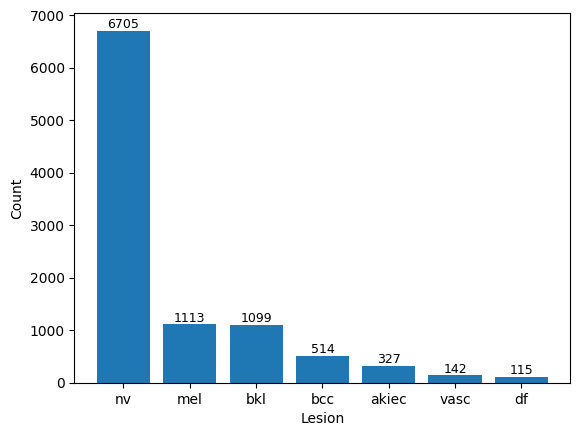

In [ ]:
# Check the target variable's distribution
bar_chart(metadata, 'dx', 'Lesion', fontsize=9)

In [ ]:
# Check for missing values
metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [ ]:
# Check for duplicate lesions
metadata.duplicated('lesion_id').sum()

2545

### Initial Preprocessing
<a id='initial-preproc'></a>

In [6]:
# Create a column with the original index for later checks
metadata['original_index'] = metadata.index

# Divide the metadata into the train and test sets and reset respective indices
train_metadata = metadata[metadata['train'] == 1].drop(['train'], axis=1)
test_metadata = metadata[metadata['train'] == 0].drop(['train'], axis=1)

train_metadata = train_metadata.reset_index(drop=True)
test_metadata = test_metadata.reset_index(drop=True)

# Create a column with the original train set index for later checks
train_metadata['original_train_index'] = train_metadata.index
test_metadata['original_test_index'] = test_metadata.index

In [7]:
del metadata
gc.collect()

7

In [8]:
# Extract hair, resize, normalize train and test images
preproc_images_data_train = inicial_preproc(images_data_train)
preproc_images_data_test = inicial_preproc(images_data_test)

In [9]:
del images_data_test
gc.collect()

0

In [10]:
# Converting labels to numpy arrays
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

# Defining the encoder
labelEncoder = LabelEncoder()

# Tranform train and test labels into numerical data
labels_train = labelEncoder.fit_transform(labels_train)
labels_test = labelEncoder.transform(labels_test)

# Check the encoding correspondance
label_mapping = {i: label for i, label in enumerate(labelEncoder.classes_)}
print(', '.join(f'{encoded}: {original}' for encoded, original in label_mapping.items()))

0: akiec, 1: bcc, 2: bkl, 3: df, 4: mel, 5: nv, 6: vasc


### Train Test Split
<a id='train-test-split'></a>

In [16]:
# Train test split
X_train, X_val, y_train, y_val, metadata_train, metadata_val = train_test_split(
    preproc_images_data_train, 
    labels_train, 
    train_metadata, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels_train, 
    shuffle=True
)

In [17]:
del preproc_images_data_train, labels_train, train_metadata
gc.collect()

1570

In [18]:
# Create a duplicate column and a respective mask to check for duplicates in the train set
metadata_train['duplicates'] = metadata_train.duplicated('lesion_id').astype(int)
mask = (metadata_train['duplicates'] != 1).values

# Extract duplicates from train data
X_train = X_train[mask]
y_train = y_train[mask]
metadata_train = metadata_train[mask]

# Drop the duplicates column as it's no longer needed and reset the index
metadata_train = metadata_train.drop(['duplicates'], axis=1)
metadata_train = metadata_train.reset_index(drop=True)

In [19]:
del mask
gc.collect()

0

### Oversampling
<a id='oversampling'></a>

In [20]:
# Creating a column with the current index to later make the oversampling image associations easier
metadata_train['new_index'] = range(len(metadata_train))

In [21]:
# Define the oversampling strategy
# - dont oversample the majority class
# - oversample the minority classes to half of the majority class

sampling_strategy = {
    'nv': 3508,
    'bkl': 1750,
    'mel': 1750,
    'bcc': 1750,
    'akiec': 1750,
    'vasc': 1750,
    'df': 1750
}

# Oversample the train set
oversample = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
metadata_train_over, y_over = oversample.fit_resample(metadata_train, metadata_train['dx'])

In [22]:
del oversample, sampling_strategy
gc.collect()

7

In [23]:
# Create the oversampled lists of images and labels and store them as numpy arrays
X_train_over = np.array([X_train[i] for i in metadata_train_over['new_index']])
y_train_over = np.array([y_train[i] for i in metadata_train_over['new_index']])

# Drop the new index column as it's no longer needed
metadata_train_over = metadata_train_over.drop(['new_index'], axis=1)

In [24]:
del X_train, y_train
gc.collect()

14

In [25]:
# Check if the oversampling was successful
metadata_train_over['dx'].value_counts()

dx
nv       3508
akiec    1750
mel      1750
bkl      1750
bcc      1750
df       1750
vasc     1750
Name: count, dtype: int64

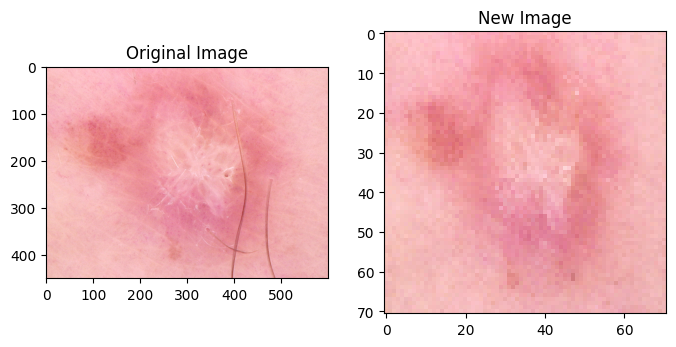

In [30]:
# Plot the before and after of the image preprocessing of a random image
# Useful to check if any mistakes were made during the preprocessing
plot_befor_after(metadata_train_over, images_data_train, X_train_over)

In [31]:
del images_data_train
gc.collect()

31705

### Modelling
<a id='modeling'></a>

In [32]:
# Define the callbacks

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [33]:
# Defining the pretrained model
base_model= Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(71,71,3),
    pooling='avg',
)

In [34]:
# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [35]:
# Defining the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.summary()

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="relu"))
model.add(Dense(7, activation="softmax"))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 20,861,480
Trainable params: 0
Non-trainable params: 20,861,480
_________________________________________________________________


In [36]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Define and fit the image data generator to our training data
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.2, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_train_over)

In [38]:
# Fit the model
history = model.fit(datagen.flow(X_train_over,y_train_over, batch_size=256),
                              epochs = 10, validation_data = (X_val,y_val),
                              verbose = 1, callbacks = early_stop)

Epoch 1/10
55/55 [==============================] - 193s 3s/step - loss: 1.5752 - accuracy: 0.4072 - val_loss: 1.2581 - val_accuracy: 0.6148
Epoch 2/10
55/55 [==============================] - 168s 3s/step - loss: 1.3139 - accuracy: 0.5131 - val_loss: 1.1282 - val_accuracy: 0.6241
Epoch 3/10
55/55 [==============================] - 169s 3s/step - loss: 1.1970 - accuracy: 0.5570 - val_loss: 1.1132 - val_accuracy: 0.6174
Epoch 4/10
55/55 [==============================] - 168s 3s/step - loss: 1.1246 - accuracy: 0.5810 - val_loss: 1.1039 - val_accuracy: 0.6121
Epoch 5/10
55/55 [==============================] - 171s 3s/step - loss: 1.0816 - accuracy: 0.5956 - val_loss: 1.1071 - val_accuracy: 0.5941
Epoch 6/10
55/55 [==============================] - 169s 3s/step - loss: 1.0548 - accuracy: 0.6063 - val_loss: 1.0768 - val_accuracy: 0.5961
Epoch 7/10
55/55 [==============================] - 168s 3s/step - loss: 1.0159 - accuracy: 0.6201 - val_loss: 1.1057 - val_accuracy: 0.5862
Epoch 8/10
55

In [39]:
# PART 1 - BASE MODEL PERFORMANCE
train_pred = model.predict(X_train_over, batch_size=64, verbose=1)
train_pred = np.argmax(train_pred, axis=1)

predictions = model.predict(X_val, batch_size=64, verbose=1)
predictions = np.argmax(predictions, axis=1)

metrics(y_train_over, train_pred, y_val, predictions)

24/24 [==============================] - 20s 707ms/step
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1750
           1       0.46      0.67      0.54      1750
           2       0.44      0.25      0.32      1750
           3       0.68      0.70      0.69      1750
           4       0.67      0.31      0.42      1750
           5       0.67      0.81      0.74      3508
           6       0.83      0.82      0.83      1750

    accuracy                           0.61     14008
   macro avg       0.61      0.58      0.58     14008
weighted avg       0.61      0.61      0.60     14008

0.6123643632210166
[[ 9

In [40]:
# Unfreeze the last 2 layers of the base model
for layer in base_model.layers[:-2]:
    layer.trainable = True

In [41]:
model.summary(show_trainable=True)

# Compile the fine tuning model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate to prevent overfitting
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Fit the fine tuning model
print("Fitting the fine-tuning model")
history2 = model.fit(datagen.flow(X_train_over,y_train_over), epochs=8, validation_data=(X_val,y_val))

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 xception (Functional)       (None, 2048)              20861480  Y          
                                                                            
 flatten (Flatten)           (None, 2048)              0         Y          
                                                                            
 dense (Dense)               (None, 256)               524544    Y          
                                                                            
 dropout (Dropout)           (None, 256)               0         Y          
                                                                            
 dense_1 (Dense)             (None, 128)               32896     Y          
                                                                            
 dense_2 (Dense)             (None, 7)                 9

In [81]:
# PART 2 - FINE TUNED MODEL PERFORMANCE
train_pred = model.predict(X_train_over, batch_size=64, verbose=1)
train_pred = np.argmax(train_pred, axis=1)

predictions_val = model.predict(X_val, batch_size=64, verbose=1)
predictions_val = np.argmax(predictions_val, axis=1)

metrics(y_train_over, train_pred, y_val, predictions_val)

24/24 [==============================] - 18s 604ms/step
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1750
           1       0.82      0.77      0.79      1750
           2       0.58      0.58      0.58      1750
           3       0.91      0.96      0.93      1750
           4       0.58      0.56      0.57      1750
           5       0.78      0.84      0.81      3508
           6       0.99      0.88      0.93      1750

    accuracy                           0.78     14008
   macro avg       0.78      0.77      0.77     14008
weighted avg       0.78      0.78      0.78     14008

0.7761993146773273
[[13

In [43]:
# Save the model
# model.save(path + 'models//best_model_images.h5')

In [3]:
# Load the model
best_model_images = load_model(path + 'models//best_model_images.h5')

In [7]:
preproc_images_data_test = np.load(path + 'new_data//X_test.npy')
predictions_test = np.load(path + 'new_data//predictions_test.npy')
labels_test = np.load(path + 'new_data//y_test.npy')

In [8]:
# Predictions on the test set (trained in train_over)
predictions_test = best_model_images.predict(preproc_images_data_test, batch_size=64, verbose=1)
predictions_test = np.argmax(predictions_test, axis=1)

metrics_test(labels_test, predictions_test)

40/40 [==============================] - 30s 685ms/step
___________________________________________________________________________________________________________
                                                    TEST                                                   
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.39      0.54      0.45        82
           1       0.59      0.61      0.60       129
           2       0.47      0.53      0.50       275
           3       0.31      0.72      0.43        29
           4       0.36      0.47      0.41       278
           5       0.91      0.80      0.85      1676
           6       0.71      0.77      0.74        35

    accuracy                           0.71      2504
   macro avg       0.53      0.64      0.57      2504
weighted avg       0.76      0.71      0.73      2504

0.7148562300319489


In [58]:
# Join the training and validation set to train the final model
X_all = np.concatenate((X_train_over, X_val), axis=0)
y_all = np.concatenate((y_train_over, y_val), axis=0)

# Fit the image data generator to our training data
datagen.fit(X_all)

In [73]:
# Fit the final model
history3 = best_model_images.fit(datagen.flow(X_all,y_all), epochs=8, validation_data=(preproc_images_data_test,labels_test))

Epoch 1/8
485/485 [==============================] - 1234s 3s/step - loss: 0.5841 - accuracy: 0.7747 - val_loss: 0.8024 - val_accuracy: 0.7400
Epoch 2/8
485/485 [==============================] - 1058s 2s/step - loss: 0.5531 - accuracy: 0.7901 - val_loss: 0.7789 - val_accuracy: 0.7320
Epoch 3/8
485/485 [==============================] - 1064s 2s/step - loss: 0.5166 - accuracy: 0.8058 - val_loss: 0.7449 - val_accuracy: 0.7408
Epoch 4/8
485/485 [==============================] - 1023s 2s/step - loss: 0.4975 - accuracy: 0.8128 - val_loss: 0.8102 - val_accuracy: 0.7376
Epoch 5/8
485/485 [==============================] - 1027s 2s/step - loss: 0.4705 - accuracy: 0.8242 - val_loss: 0.7134 - val_accuracy: 0.7500
Epoch 6/8
485/485 [==============================] - 1017s 2s/step - loss: 0.4559 - accuracy: 0.8306 - val_loss: 0.7263 - val_accuracy: 0.7472
Epoch 7/8
485/485 [==============================] - 1024s 2s/step - loss: 0.4307 - accuracy: 0.8395 - val_loss: 0.6787 - val_accuracy: 0.7668

In [161]:
# Predictions on the test set (train_over + val)
predictions_all = best_model_images.predict(preproc_images_data_test, batch_size=64, verbose=1)
predictions_all = np.argmax(predictions_all, axis=1)

metrics_test(labels_test, predictions_all)

40/40 [==============================] - 34s 796ms/step
___________________________________________________________________________________________________________
                                                    TEST                                                   
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.56      0.50        82
           1       0.65      0.67      0.66       129
           2       0.49      0.62      0.55       275
           3       0.47      0.62      0.54        29
           4       0.48      0.49      0.48       278
           5       0.92      0.85      0.88      1676
           6       0.71      0.77      0.74        35

    accuracy                           0.76      2504
   macro avg       0.59      0.65      0.62      2504
weighted avg       0.78      0.76      0.77      2504

0.7635782747603834


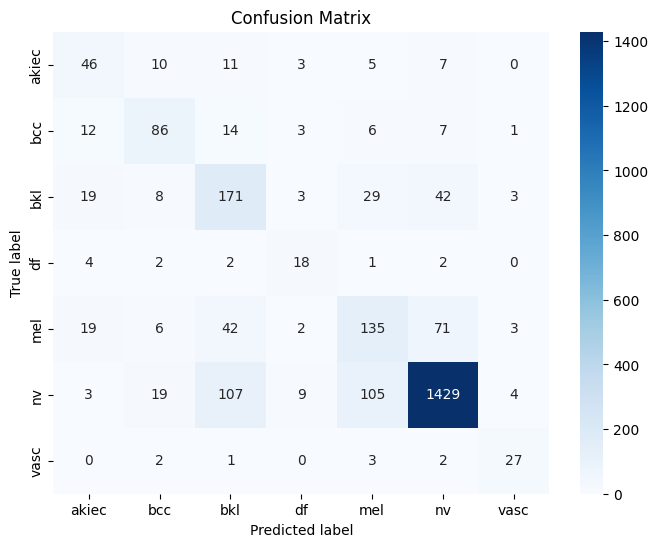

In [170]:
# Confusion matrix for the final model's predictions
plot_confusion_matrix(labels_test, predictions_all)

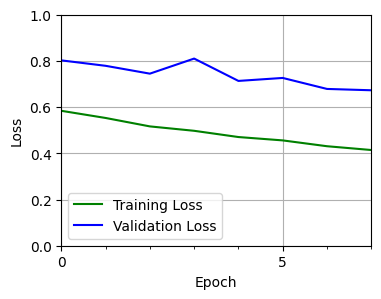

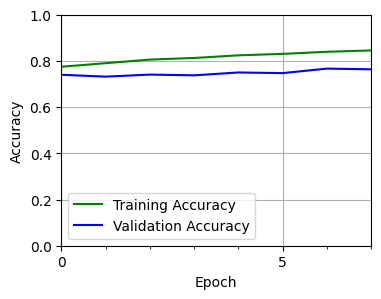

In [94]:
# Plot the train and validation loss and accuracy
train_loss, train_acc = history3.history["loss"], history3.history["accuracy"]
valid_loss, valid_acc = history3.history["val_loss"], history3.history["val_accuracy"]

plot_results([ train_loss, valid_loss ], ylabel="Loss", ylim = [0.0, 1.0], 
             metric_name=["Training Loss", "Validation Loss"], color=["g", "b"])

plot_results([ train_acc, valid_acc ], ylabel="Accuracy", ylim = [0.0, 1.0], 
             metric_name=["Training Accuracy", "Validation Accuracy"], color=["g", "b"])

In [159]:
# Saving the final model
# model.save(path + 'models//final_model.h5')

### Check results
<a id='check results'></a>

In [9]:
# Load the final model
final_model = load_model(path + 'models//final_model.h5')

1/1 [==============================] - 1s 1s/step


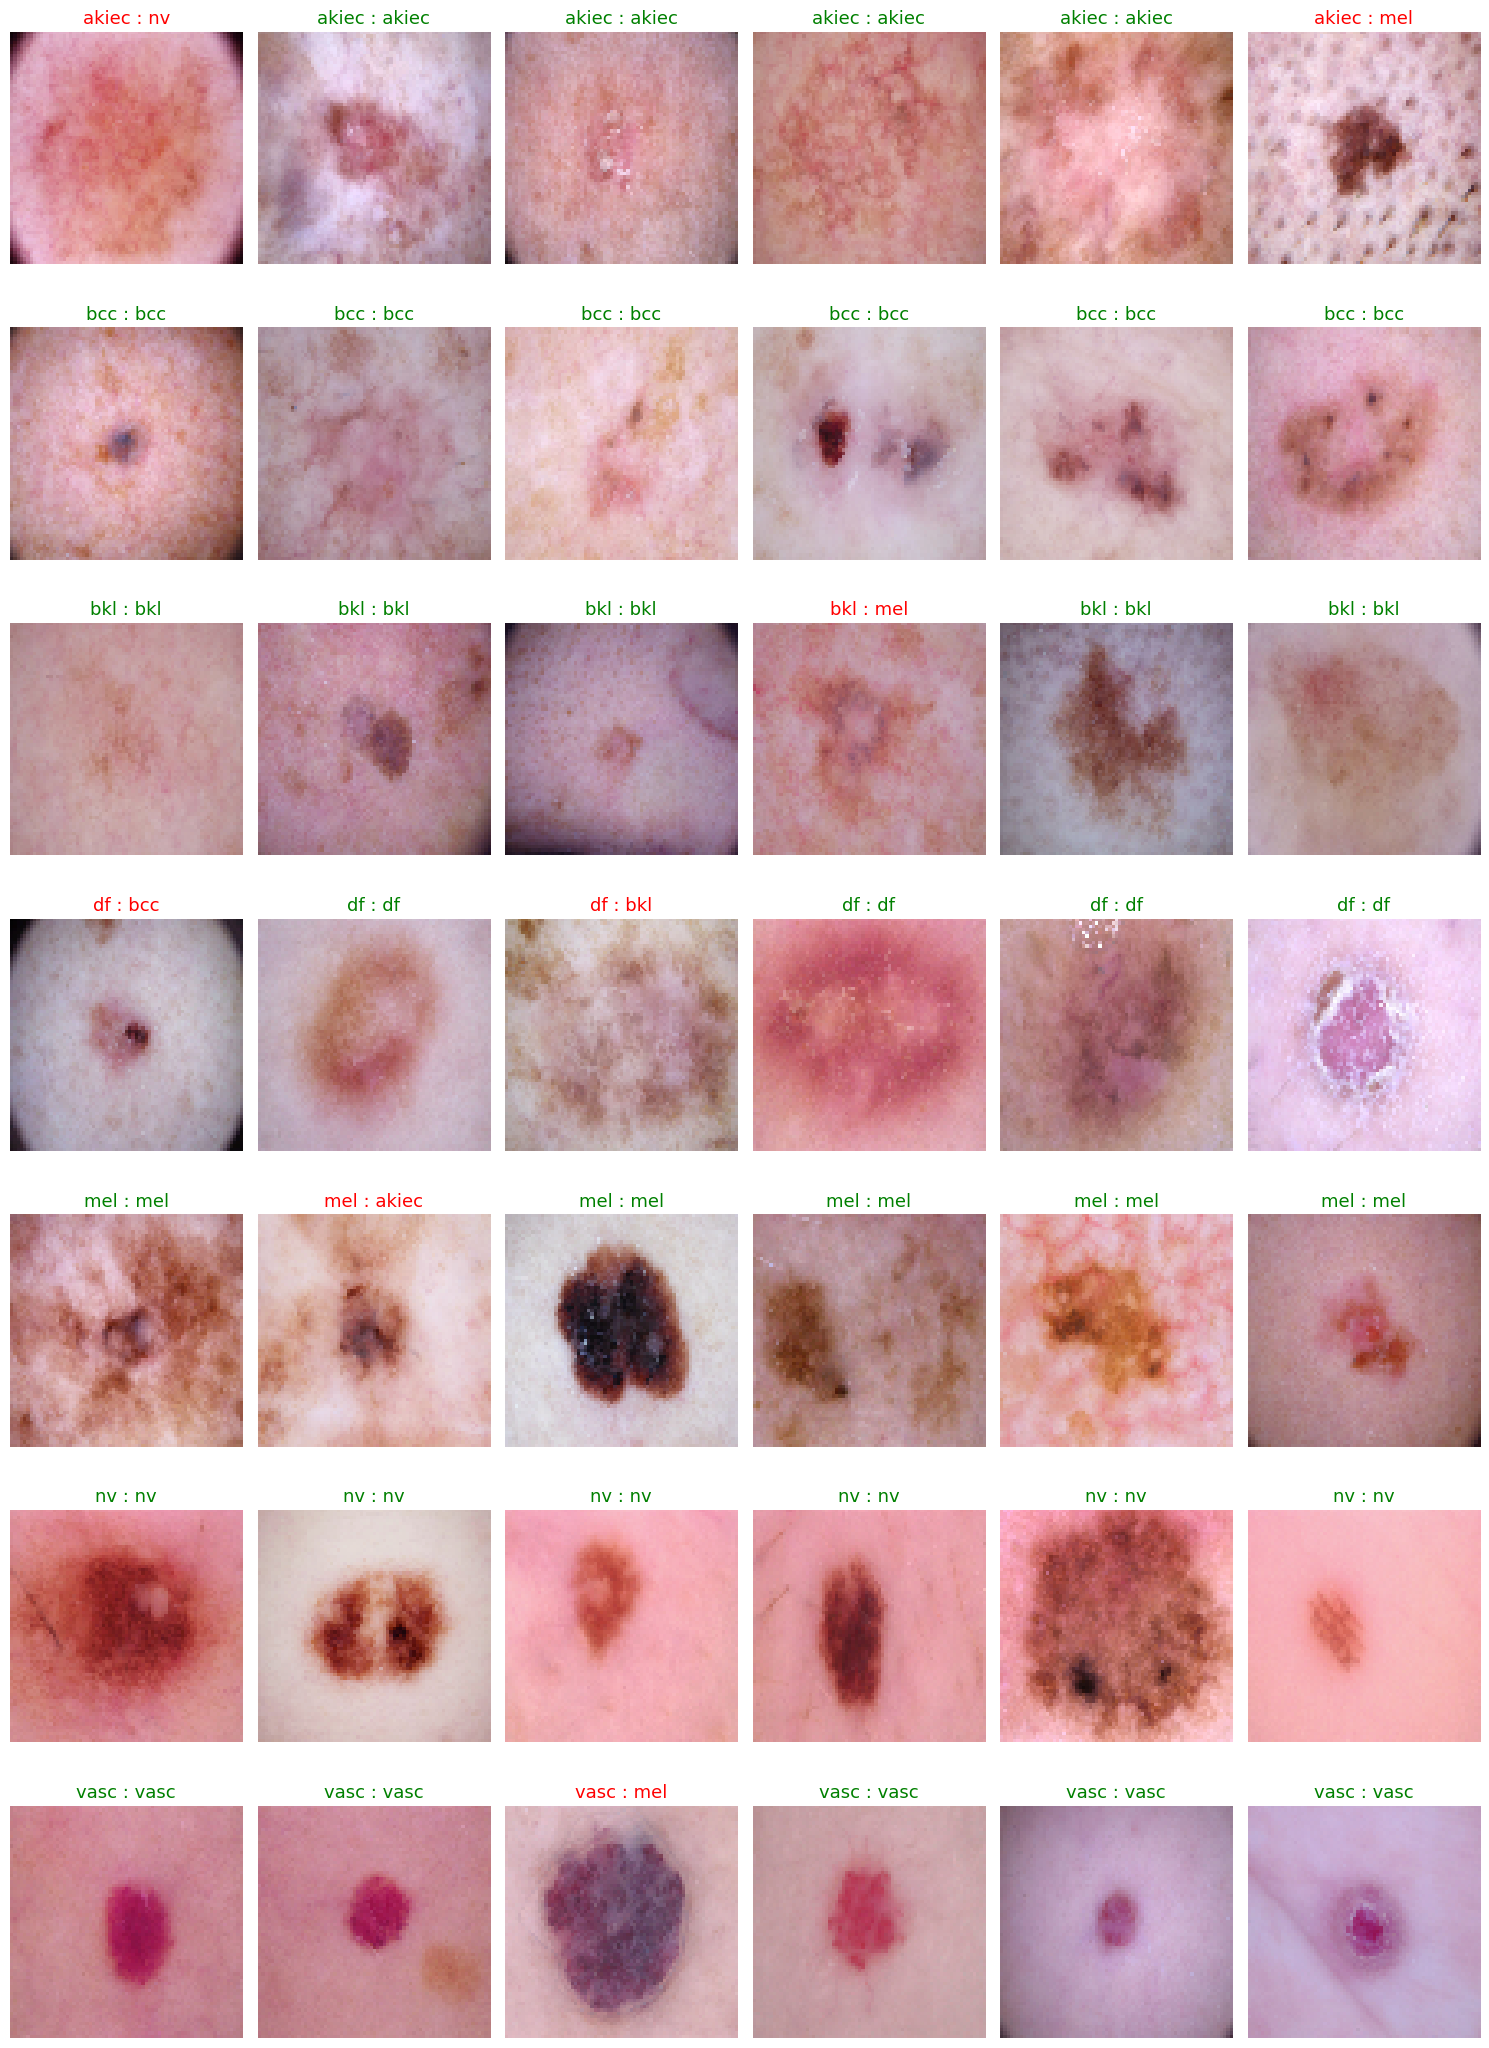

Overall accuracy: 0.83


In [158]:
# Check model performance for each class
evaluate_model(preproc_images_data_test, labels_test, final_model)

### Exporting necessary information
<a id='exports'></a>

In [49]:
# metadata_train.to_csv(path + 'new_data//metadata_train.csv', index=False)
# metadata_train_over.to_csv(path + 'new_data//metadata_train_over.csv', index=False)
# metadata_val.to_csv(path + 'new_data//metadata_val.csv', index=False)
# test_metadata.to_csv(path + 'new_data//test_metadata.csv', index=False)

In [52]:
# np.save(path + 'new_data//X_train_over.npy', X_train_over)
# np.save(path + 'new_data//y_train_over.npy', y_train_over)
# np.save(path + 'new_data//X_val.npy', X_val)
# np.save(path + 'new_data//y_val.npy', y_val)
# np.save(path + 'new_data//X_test.npy', preproc_images_data_test)
# np.save(path + 'new_data//y_test.npy', labels_test)
# np.save(path + 'new_data//X_all.npy', X_all)
# np.save(path + 'new_data//y_all.npy', y_all)
# np.save(path + 'new_data//predictions_all.npy', predictions_all)
# np.save(path + 'new_data//predictions_val.npy', predictions)
# np.save(path + 'new_data//predictions_test.npy', predictions_test)